# Analysis: Machine Learning Approaches
**Primary Analyst:** Alvin Jeffery

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn import preprocessing, model_selection
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import make_scorer, confusion_matrix, f1_score, roc_auc_score

from hpsklearn import HyperoptEstimator, standard_scaler, demo_support
from hpsklearn import random_forest, extra_trees, gradient_boosting, xgboost_classification
from hyperopt import tpe, hp

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


### Load Data

In [2]:
train = pd.read_csv('../data/train_imputed.csv').drop(columns='Unnamed: 0')
valid = pd.read_csv('../data/valid_imputed.csv').drop(columns='Unnamed: 0')
test = pd.read_csv('../data/test_imputed.csv').drop(columns='Unnamed: 0')

In [3]:
y_train = train.pop('readmit_30d')
X_train = train.copy()
X_train.shape

(12912, 208)

In [4]:
y_valid = valid.pop('readmit_30d')
X_valid = valid.copy()
X_valid.shape

(3992, 208)

In [5]:
y_test = test.pop('readmit_30d')
X_test = test.copy()
X_test.shape

(4229, 208)

### Coerce Categories (`sex` and `race`)

In [6]:
X_train = pd.get_dummies(X_train, columns=['sex', 'race'])
X_train.head()

,stay_length,n_transfers,cpt_anesthesia,cpt_eval_manage,cpt_expired,cpt_medicine,cpt_modifier,cpt_path_lab,cpt_radiology,cpt_surgery,...,sex_F,sex_M,sex_U,race_A,race_B,race_H,race_I,race_N,race_U,race_W
0,4,2,0,6,4,16,9,24,9,2,...,1,0,0,0,0,0,0,0,0,1
1,3,3,0,2,1,16,15,39,1,0,...,1,0,0,0,0,0,0,0,0,1
2,1,1,0,3,0,7,4,13,1,0,...,1,0,0,0,0,0,0,0,0,1
3,4,2,0,6,1,4,8,47,2,2,...,1,0,0,0,0,0,0,0,0,1
4,1,1,0,1,1,2,3,21,1,0,...,1,0,0,0,0,0,0,0,0,1


In [7]:
X_valid = pd.get_dummies(X_valid, columns=['sex', 'race'])
X_test = pd.get_dummies(X_test, columns=['sex', 'race'])

---
## Hyperparameter Tuning with Hyperopt

In [8]:
# convert to numpy arrays for passing to hyperopt
X_train_np = X_train.values
y_train_np = y_train.values

In [9]:
X_valid_np = X_valid.values
y_valid_np = y_valid.values

In [10]:
seed = 42
jobs = 3

clf = hp.pchoice('readmissions', 
          [(0.33, random_forest('readmissions.random_forest', 
                                n_jobs=jobs, random_state=seed)),
           (0.33, gradient_boosting('readmission.gbc',
                                random_state=seed)), # n_jobs not an argument
           #(0.0, xgboost_classification('readmissions.xgb',
           #                     random_state=seed)), # n_jobs not an argument in hyperopt (unlike sklearn)
           (0.33, extra_trees('readmissions.extra_trees',
                                n_jobs=jobs, random_state=seed))])

In [11]:
timeout = 15 * 60 # timeout (seconds)

estim = HyperoptEstimator(algo=tpe.suggest, 
                          preprocessing=[standard_scaler('standard_scaler')],
                          classifier=clf,
                          max_evals=300,
                          verbose=True,
                          trial_timeout=timeout)

### Run Hyperopt
Prints each iteration of the algorithm. Produces cumulative graph of accuracy with each attempt. 

In [12]:
import time
from IPython import display

def scatter_error_vs_time(estimator, ax):
    losses = estimator.trials.losses()
    ax.set_ylabel('Validation error rate')
    ax.set_xlabel('Iteration')
    ax.scatter(list(range(len(losses))), losses)

class PlotHelper(object):

    def __init__(self, estimator):
        self.estimator = estimator
        self.fig, self.axs = plt.subplots(1, 2)
        self.post_iter_wait = .5

    def post_iter(self):
        self.axs[0].clear()
        self.axs[1].clear()
        scatter_error_vs_time(self.estimator, self.axs[0])
        display.clear_output()
        display.display(self.fig)
        time.sleep(self.post_iter_wait)

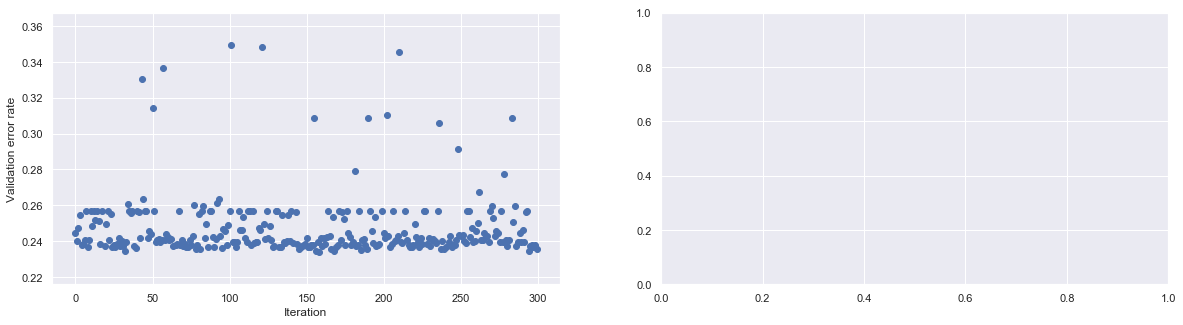

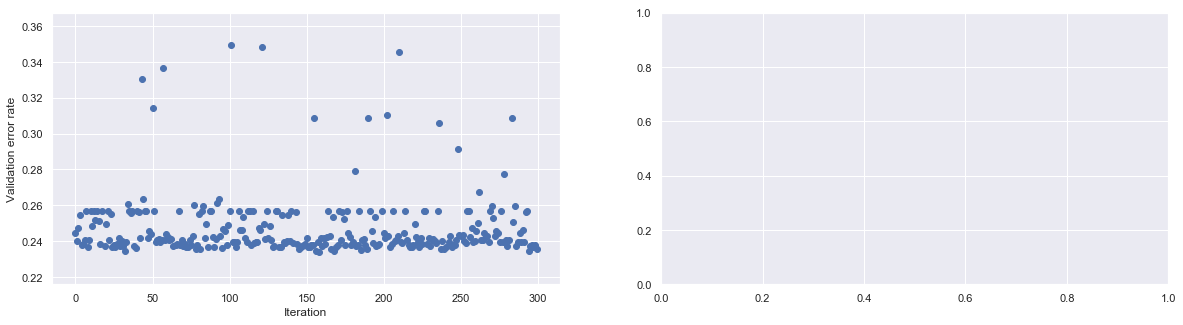

In [26]:
# create generator to assess each step
fit_iterator = estim.fit_iter(X_train_np, y_train_np)
next(fit_iterator)

plt.rcParams["figure.figsize"] = (20, 5)
plot_helper = PlotHelper(estim)

while len(estim.trials.trials) < estim.max_evals:
    fit_iterator.send(1) 
    plot_helper.post_iter()

In [27]:
estim.retrain_best_model_on_full_data(X_train_np, y_train_np)

Fitting StandardScaler(copy=True, with_mean=False, with_std=False) to X of shape (12912, 216)
Transforming Xfit (12912, 216)
Training learner RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.488733432326353,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=46,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=253, n_jobs=3, oob_score=False, random_state=42,
            verbose=False, warm_start=False) on X/EX of dimension (12912, 216)


In [29]:
model = estim.best_model()
model

{'learner': RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
             max_depth=None, max_features=0.488733432326353,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=46,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=253, n_jobs=3, oob_score=False, random_state=42,
             verbose=False, warm_start=False),
 'preprocs': (StandardScaler(copy=True, with_mean=False, with_std=False),),
 'ex_preprocs': ()}

### End Hyperopt Run
---

## Apply Best Hyperopt Model to Data

In [13]:
best = RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
             max_depth=None, max_features=0.488733432326353,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=46,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=253, n_jobs=3, oob_score=False, random_state=42,
             verbose=False, warm_start=False)

In [17]:
best.fit(X_train, y_train)

KeyboardInterrupt: 

In [15]:
def ml_eval(X, y, model):
    """
    Helper function to review evaluation of model w.r.t. accuracy, AUC, and F1 score
    """
    predictions = model.predict(X)
    print('Accuracy: %.3f' % model.score(X, y))
    print('AUC:      %.3f' % roc_auc_score(y, predictions))
    print('F1 Score: %.3f' % f1_score(y, predictions))
    print('Confusion Matrix:')
    print(confusion_matrix(y, predictions))

In [16]:
ml_eval(X_train, y_train, best)

Accuracy: 0.789
AUC:      0.624
F1 Score: 0.404
Confusion Matrix:
[[9268  126]
 [2597  921]]


In [101]:
ml_eval(X_valid, y_valid, best)

Accuracy: 0.744
AUC:      0.511
F1 Score: 0.050
Confusion Matrix:
[[2942   14]
 [1009   27]]


In [102]:
X_train_valid = pd.concat([X_train, X_valid], ignore_index=True)
y_train_valid = pd.concat([y_train, y_valid], ignore_index=True)

In [109]:
best.fit(X_train_valid, y_train_valid)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.488733432326353,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=46,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=253, n_jobs=3, oob_score=False, random_state=42,
            verbose=False, warm_start=False)

In [110]:
ml_eval(X_train_valid, y_train_valid, best)

Accuracy: 0.784
AUC:      0.609
F1 Score: 0.364
Confusion Matrix:
[[12211   139]
 [ 3510  1044]]


### Scitkit-Learn Grid Search

Given that hyperopt appeared to focus on accuracy, I'm using a grid search (inclusive of hyperopt hyperparameters) to explore whether better F1 resuts are possible. 

In [153]:
max_features = [0.25, 0.5, 0.75]
n_estimators = [250, 500, 750]

parameter_grid = {'max_features': max_features, 
                  'n_estimators': n_estimators}

In [154]:
rf = RandomForestClassifier(random_state=42)
rf_cv = model_selection.GridSearchCV(estimator=rf, 
                                      cv=5, 
                                      n_jobs=3, 
                                      param_grid=parameter_grid,
                                      scoring=make_scorer(f1_score))

rf_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=3,
       param_grid={'max_features': [0.25, 0.5, 0.75], 'n_estimators': [250, 500, 750]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(f1_score), verbose=0)

In [155]:
rf_cv.best_estimator_.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 0.25,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 250,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [156]:
ml_eval(X_train, y_train, rf_cv.best_estimator_)

Accuracy: 1.000
AUC:      1.000
F1 Score: 1.000
Confusion Matrix:
[[9394    0]
 [   0 3518]]


In [157]:
ml_eval(X_valid, y_valid, rf_cv.best_estimator_)

Accuracy: 0.741
AUC:      0.510
F1 Score: 0.058
Confusion Matrix:
[[2925   31]
 [1004   32]]


In [158]:
df0 = pd.DataFrame(rf_cv.cv_results_)
df = df0[['param_max_features', 'param_n_estimators', 'mean_test_score']]
df.head()

/Volumes/AlvinSD/anaconda3/envs/Bios8366/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Volumes/AlvinSD/anaconda3/envs/Bios8366/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Volumes/AlvinSD/anaconda3/envs/Bios8366/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*war

,param_max_features,param_n_estimators,mean_test_score
0,0.25,250,0.194306
1,0.25,500,0.186253
2,0.25,750,0.186557
3,0.5,250,0.189049
4,0.5,500,0.183341


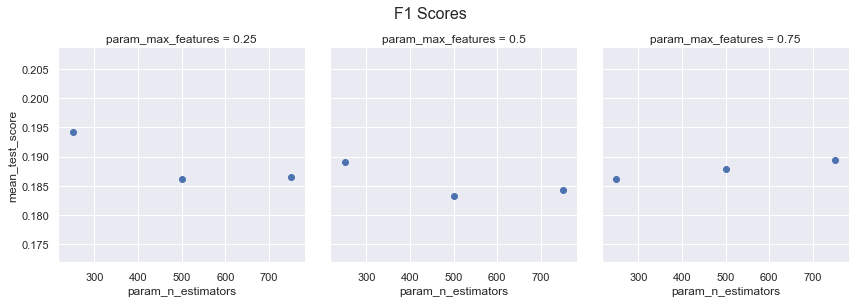

In [163]:
g = sns.FacetGrid(df, col='param_max_features', 
                  col_wrap=3, height=4)
g = (g.map(plt.scatter, 'param_n_estimators', 'mean_test_score')
      .add_legend()
      .fig.suptitle('F1 Scores', y=1.05, fontsize=16))

## Interpretation

In [111]:
def feature_importance(rf, train, pred_cols):
    importances = rf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    predictors = train[pred_cols].columns
    X = train[pred_cols]

    # Print the feature ranking
    print("Feature ranking:")
    #for f in range(X.shape[1]): # all features
    for f in range(10): # top 10 only
        print("%d. %s (%f)" % (f + 1, predictors[indices[f]], importances[indices[f]]))
    
    return X, importances, std, predictors, indices

Feature ranking:
1. lab_rdw_95p (0.067108)
2. age (0.044452)
3. lab_rdw_last_measure (0.038852)
4. med_Histamine.H1.Antagonists (0.038235)
5. med_Antiemetics (0.034416)
6. icd_dx_neoplasm (0.023572)
7. lab_rdw_median (0.017233)
8. lab_systolic_std (0.016596)
9. lab_rdw_first_measure (0.016355)
10. lab_hgb_5p (0.013203)


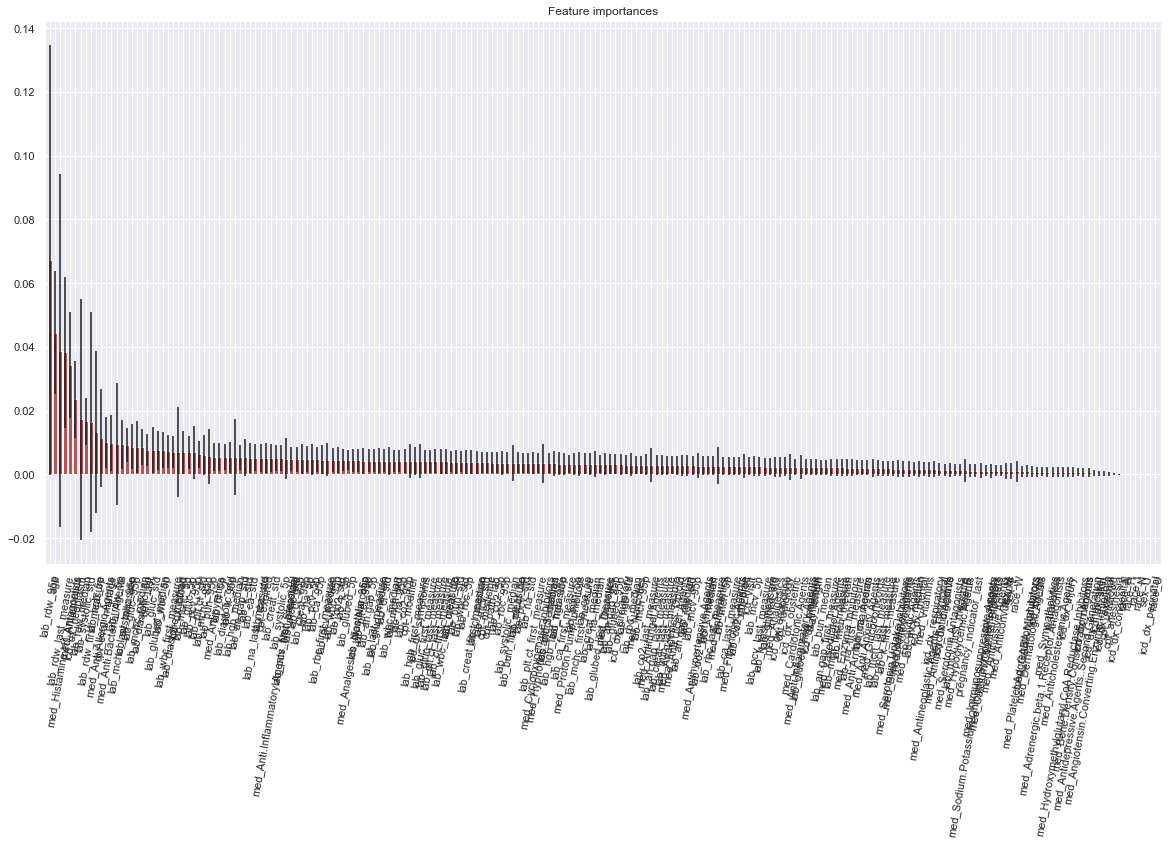

In [112]:
x, importances, std, predictors, indices = feature_importance(rf=best, 
                                                              train=X_train_valid, 
                                                              pred_cols=X_train_valid.columns)

plt.figure(figsize=(20,10)); plt.title("Feature importances")
plt.bar(range(x.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x.shape[1]), predictors[indices], rotation=80); plt.xlim([-1, x.shape[1]])
plt.show()

In [113]:
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

In [133]:
gbc = GradientBoostingClassifier(n_estimators=250, 
                                 max_features=0.5, 
                                 max_depth=5,
                                 random_state=42)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=0.5, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=250,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [134]:
ml_eval(X_train, y_train, gbc)

Accuracy: 0.920
AUC:      0.859
F1 Score: 0.832
Confusion Matrix:
[[9338   56]
 [ 972 2546]]


In [135]:
ml_eval(X_valid, y_valid, gbc)

Accuracy: 0.737
AUC:      0.533
F1 Score: 0.176
Confusion Matrix:
[[2831  125]
 [ 924  112]]


In [136]:
max_features = [0.25, 0.5, 0.75]
n_estimators = [250, 500, 750]
max_depth = [2, 3, 4, 5, 6]

# Create the grid
parameter_grid = {'max_features': max_features, 
                  'n_estimators': n_estimators,
                  'max_depth': max_depth}

In [137]:
gbc = GradientBoostingClassifier(random_state=42)
gbc_cv = model_selection.GridSearchCV(estimator=gbc, 
                                      cv=5, 
                                      n_jobs=3, 
                                      param_grid=parameter_grid,
                                      scoring=make_scorer(f1_score))

gbc_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=3,
       param_grid={'max_features': [0.25, 0.5, 0.75], 'n_estimators': [250, 500, 750], 'max_depth': [2, 3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(f1_score), verbose=0)

In [142]:
gbc_cv.best_estimator_.get_params()

{'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 4,
 'max_features': 0.75,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 750,
 'n_iter_no_change': None,
 'presort': 'auto',
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [139]:
ml_eval(X_train, y_train, gbc_cv.best_estimator_)

Accuracy: 0.967
AUC:      0.939
F1 Score: 0.935
Confusion Matrix:
[[9385    9]
 [ 423 3095]]


In [143]:
ml_eval(X_valid, y_valid, gbc_cv.best_estimator_)

Accuracy: 0.726
AUC:      0.529
F1 Score: 0.186
Confusion Matrix:
[[2772  184]
 [ 911  125]]


In [146]:
df0 = pd.DataFrame(gbc_cv.cv_results_)
df = df0[['param_max_depth', 'param_max_features', 'param_n_estimators', 'mean_test_score']]
df.head()

/Volumes/AlvinSD/anaconda3/envs/Bios8366/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Volumes/AlvinSD/anaconda3/envs/Bios8366/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Volumes/AlvinSD/anaconda3/envs/Bios8366/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*war

,param_max_depth,param_max_features,param_n_estimators,mean_test_score
0,2,0.25,250,0.254924
1,2,0.25,500,0.269734
2,2,0.25,750,0.276209
3,2,0.5,250,0.246378
4,2,0.5,500,0.262330


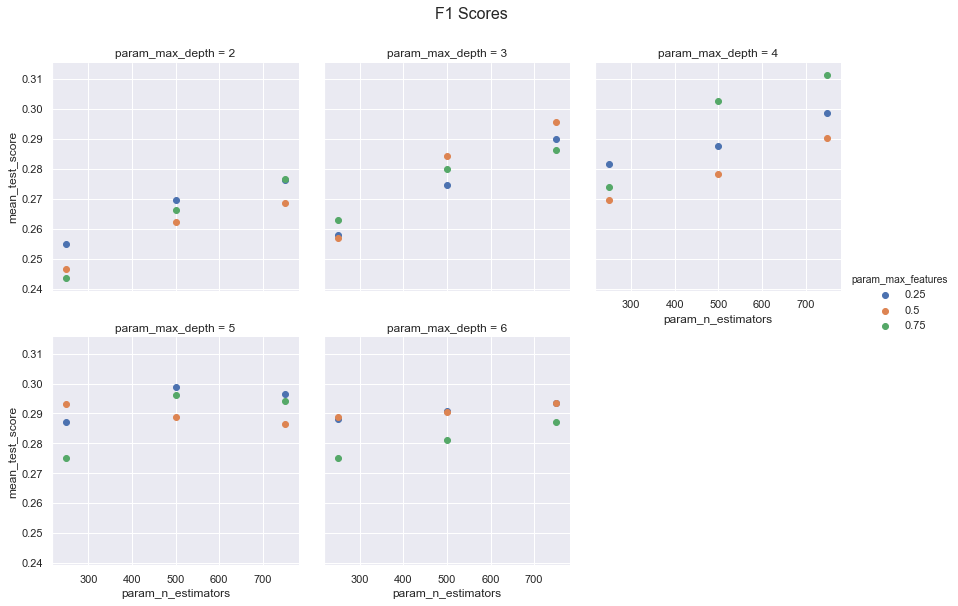

In [150]:
g = sns.FacetGrid(df, col='param_max_depth', hue='param_max_features', 
                  col_wrap=3, height=4)
g = (g.map(plt.scatter, 'param_n_estimators', 'mean_test_score')
      .add_legend()
      .fig.suptitle('F1 Scores', y=1.05, fontsize=16))

In [152]:
gbc_best = gbc_cv.best_estimator_
gbc_best.fit(X_train_valid, y_train_valid)

ml_eval(X_train_valid, y_train_valid, gbc_best)

Accuracy: 0.938
AUC:      0.887
F1 Score: 0.870
Confusion Matrix:
[[12321    29]
 [ 1022  3532]]


Text(0.5,0.98,'Partial dependence on age')

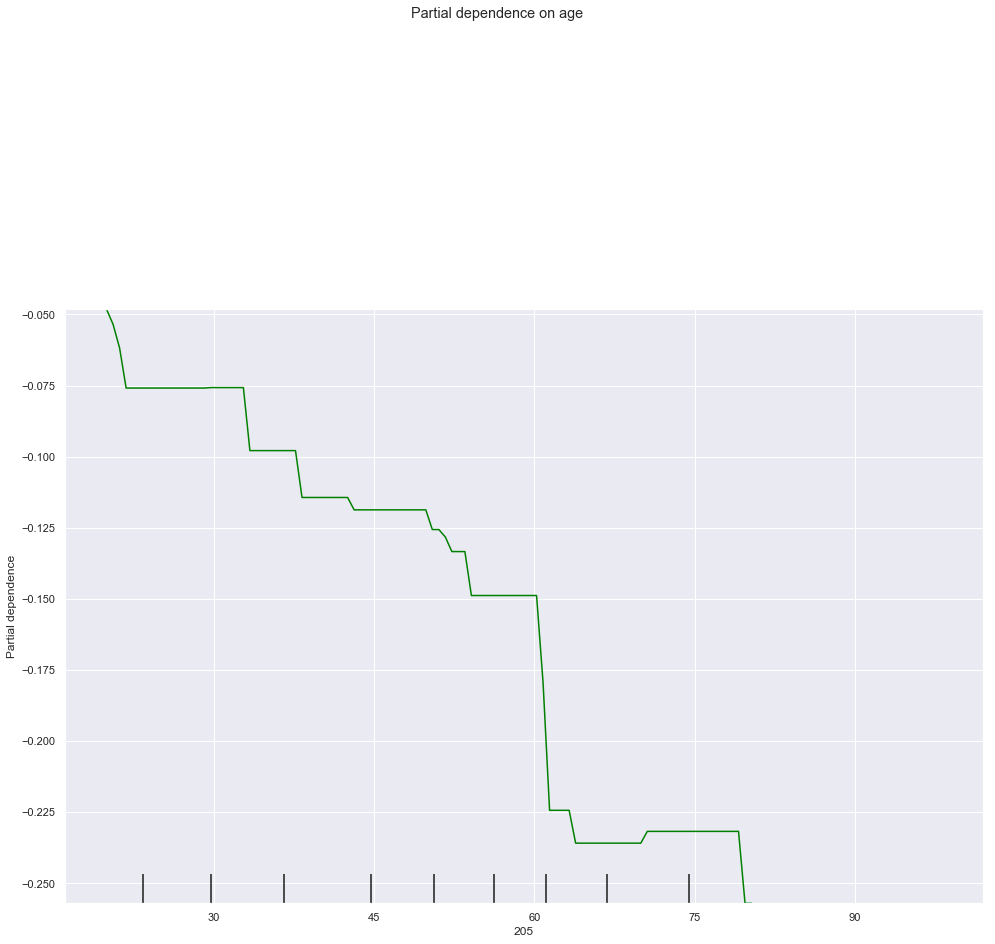

In [122]:
plt.rcParams["figure.figsize"] = (15, 15)

var = 'age'
idx = X_train.columns.get_loc(var)

my_plot, ax = plot_partial_dependence(gbc, features=[idx], X=X_train)
axes = plt.gca()
axes.set_xlim([min(X_train[var]), max(X_train[var])])
#axes.set_ylim([-0.15, 0.5])
my_plot.suptitle('Partial dependence on ' + var)

## Test Set Performance (Performed Only Once)

In [ ]:
## refit using best model but on entire train & validation sets together